In [2]:
import pandas as pd
import numpy as np
import pybnesian as pbn
import matplotlib.pyplot as plt
import os
import glob
import time
from util_funcs import *

/tmp/ipykernel_6812/2365032129.py:72: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


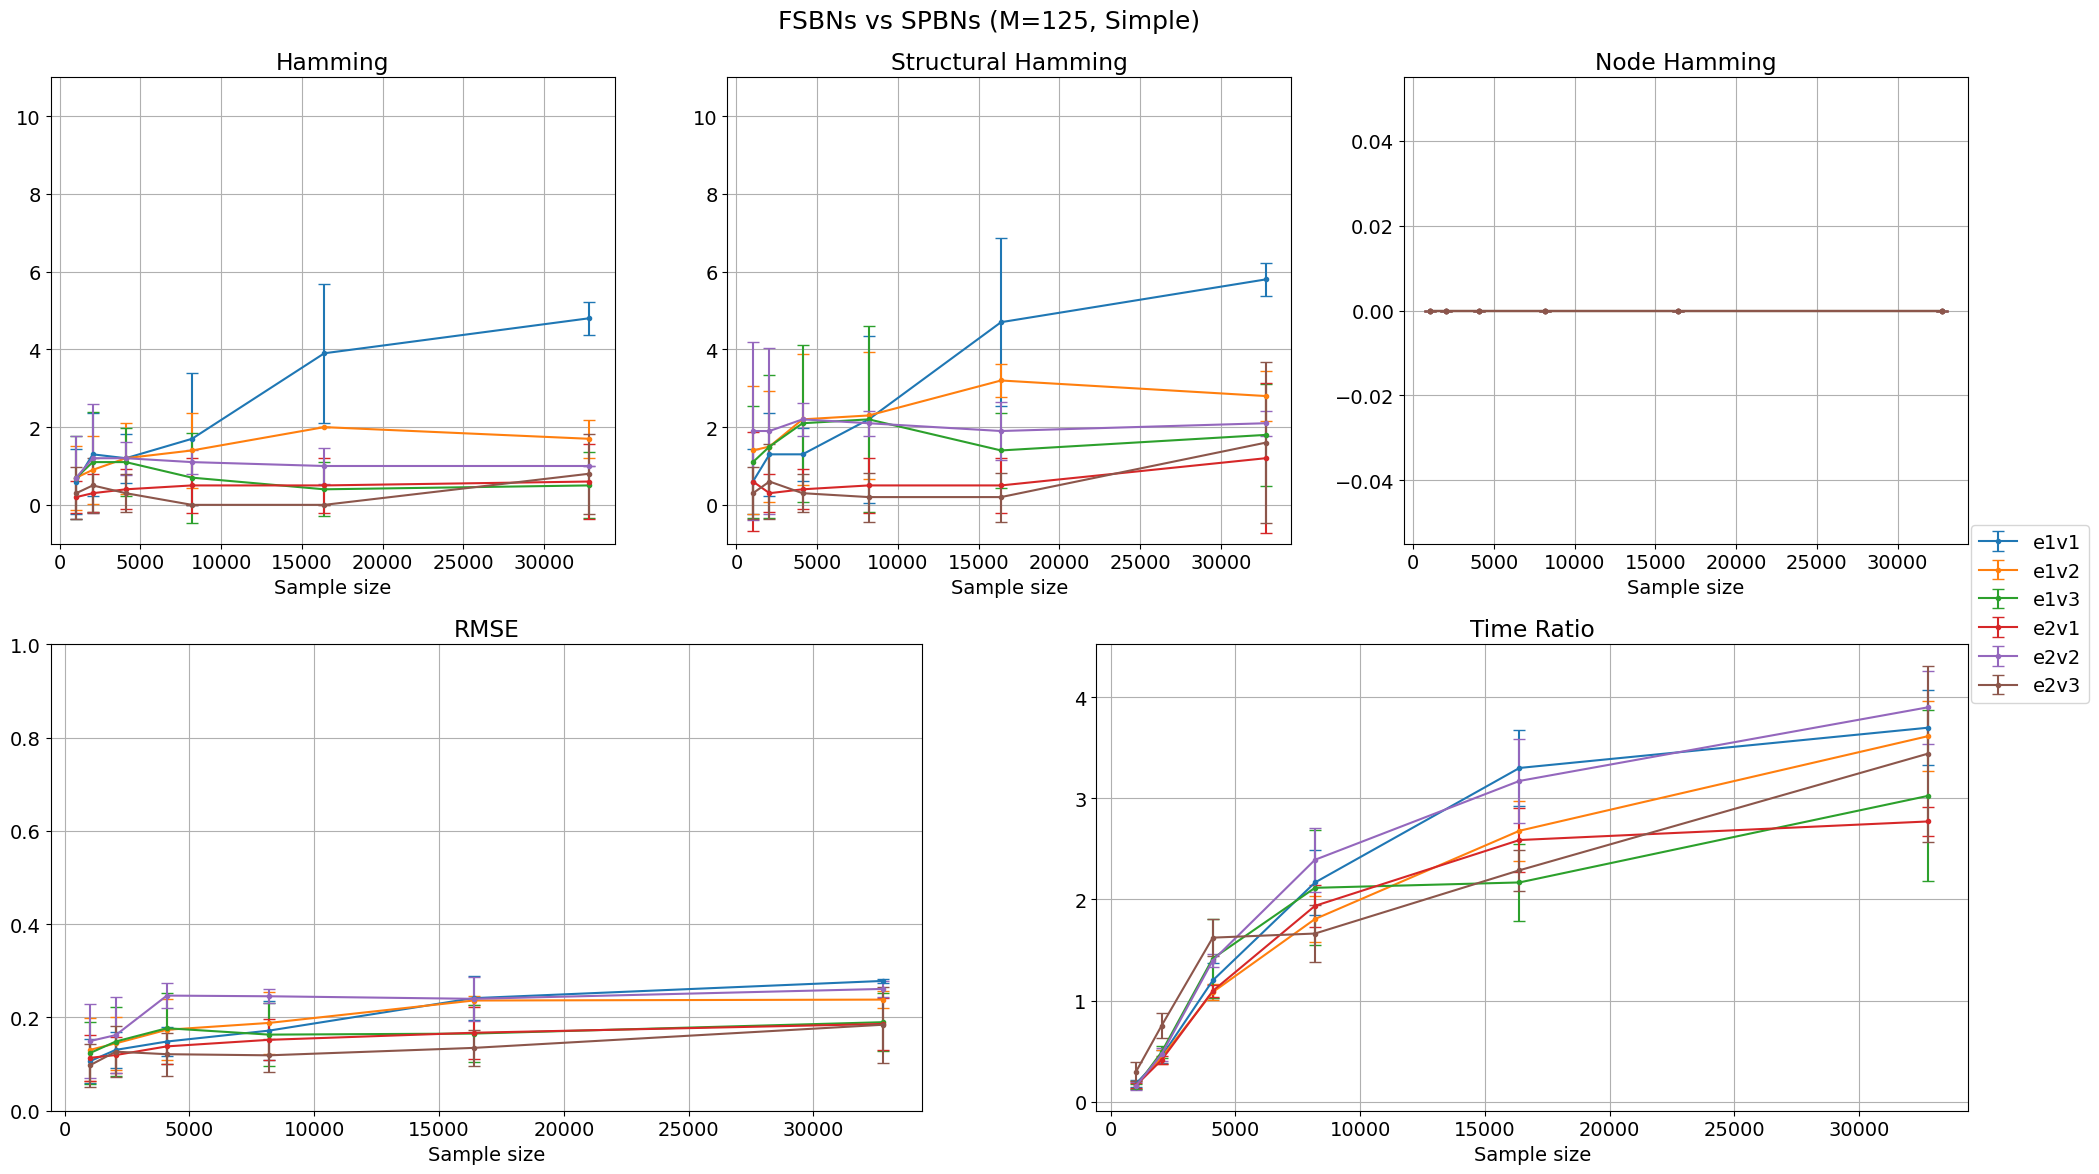

In [3]:
paths = ['results/Mfix/exp3_simple/M125/*.csv']
for path in paths:
    ress = glob.glob(path)
    ress = sorted(ress)
    hasM = path.split('/')[3][1:]


    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(20, 12), layout="constrained")
    fig.suptitle(f'FSBNs vs SPBNs (M={hasM}, Simple)', fontsize=18)
    gs0 = fig.add_gridspec(2, 1)
    gs00 = gs0[0].subgridspec(1, 3)
    gs10 = gs0[1].subgridspec(1, 2)


    ax00 = fig.add_subplot(gs00[0, 0])
    ax00.set_title('Hamming')
    ax00.set_xlabel('Sample size')
    ax00.set_ylim(-1,11)

    ax01 = fig.add_subplot(gs00[0, 1])
    ax01.set_title('Structural Hamming')
    ax01.set_xlabel('Sample size')
    ax01.set_ylim(-1,11)

    ax02 = fig.add_subplot(gs00[0, 2])
    ax02.set_title('Node Hamming')
    ax02.set_xlabel('Sample size')

    ax10 = fig.add_subplot(gs10[0, 0])  
    ax10.set_title('RMSE')
    ax10.set_xlabel('Sample size')
    ax10.set_ylim(0,1)

    ax11 = fig.add_subplot(gs10[0, 1])
    ax11.set_title('Time Ratio')
    ax11.set_xlabel('Sample size')
    # ax11.set_ylabel('Seconds')

    for nrs, res in enumerate(ress):
        filename = os.path.basename(res).split('_')[1]
        df0 = pd.read_csv(res)
        
        df0['time_diff'] = df0['time_spbn']/df0['time_fbn']
        df = df0.groupby('instances').mean().reset_index()
        dfstev = df0.groupby('instances').std().reset_index()


        ax00.errorbar(x=df['instances'], y=df['hamming'], yerr=dfstev['hamming'], fmt='o', linestyle='-', capsize=4, markersize=3, label=filename)
        ax00.grid(True)
        
        ax01.errorbar(x=df['instances'], y=df['shamming'], yerr=dfstev['shamming'], fmt='o', linestyle='-', capsize=4, markersize=3, label=filename)
        ax01.grid(True)
        
        ax02.errorbar(x=df['instances'], y=df['type_hamming'], yerr=dfstev['type_hamming'], fmt='o', linestyle='-', capsize=4, markersize=3, label=filename)   
        ax02.grid(True)
        
        ax10.errorbar(x=df['instances'], y=df['rmse'], yerr=dfstev['rmse'], fmt='o', linestyle='-',  capsize=4, markersize=3, label=filename)
        ax10.grid(True)

        ax11.errorbar(x=df['instances'], y=df['time_diff'], yerr=dfstev['time_diff'], fmt='o', linestyle='-',  capsize=4, markersize=3, label=filename)
        ax11.grid(True)


    handles, labels = [], []
    for ax in [ax00, ax01, ax02, ax10, ax11]:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:  # Check to avoid duplicates
                handles.append(handle)
                labels.append(label)
    fig.legend(handles, labels,loc='upper right', bbox_to_anchor=(1.05, 0.55), borderaxespad=0.)
    fig.tight_layout()
    fig.show()  


In [4]:
def return_results(results, nodemap):
    map_types = {0: pbn.LinearGaussianCPDType(), 1:pbn.CKDEType(), 2:pbn.FBKernelType()}
    time = results['time']
    slogl = results['slogl']
    network = results['network']

    
    nodetypes = np.array(network['node_types']).reshape(-1, 2)
    nodes_df = pd.DataFrame(nodetypes, columns=['node', 'type'])
    nodes_df.replace({'LinearGaussianFactor':0, 'CKDEFactor':1, 'FBKernelType':2}, inplace=True)
    nodes_df = nodes_df.groupby('node').mean().reset_index()
    nodes_df.type = nodes_df.type.astype(int)
    avg_node_types = [(row.node, map_types[row.type])  for row in nodes_df.itertuples()]
    avg_nodes = nodes_df['node'].values

    dags = np.array(network['DAGS'])
    avg_network = average_dags(dags,threshold=2/3)

    lengnodes = avg_network.shape[0]
    avg_arcs = []
    for i in range(lengnodes):
        for j in range(lengnodes):
            val_ij = avg_network[i,j]
            val_ji = avg_network[j,i]
            if i!=j and (val_ij>0 and val_ji==0):
                avg_arcs.append((nodemap[str(i)],nodemap[str(j)]))
            elif (val_ij>0 and val_ji>0):
                print((nodemap[str(i)],nodemap[str(j)]))
    
    network_kargs = {'node_types':avg_node_types, 'arcs':avg_arcs, 'nodes':avg_nodes}
    return time, slogl, network_kargs



/tmp/ipykernel_6812/384264639.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nodes_df.replace({'LinearGaussianFactor':0, 'CKDEFactor':1, 'FBKernelType':2}, inplace=True)
/tmp/ipykernel_6812/384264639.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nodes_df.replace({'LinearGaussianFactor':0, 'CKDEFactor':1, 'FBKernelType':2}, inplace=True)
/tmp/ipykernel_6812/384264639.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call

   instances  hamming  shamming  type_hamming
0       1024      0.0         0             0
0       2048      1.0         1             0
0       4096      1.0         1             0
0       8192      1.0         1             0
0      16384      2.0         2             0
0      32768      3.0         3             0


/tmp/ipykernel_6812/157487457.py:210: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


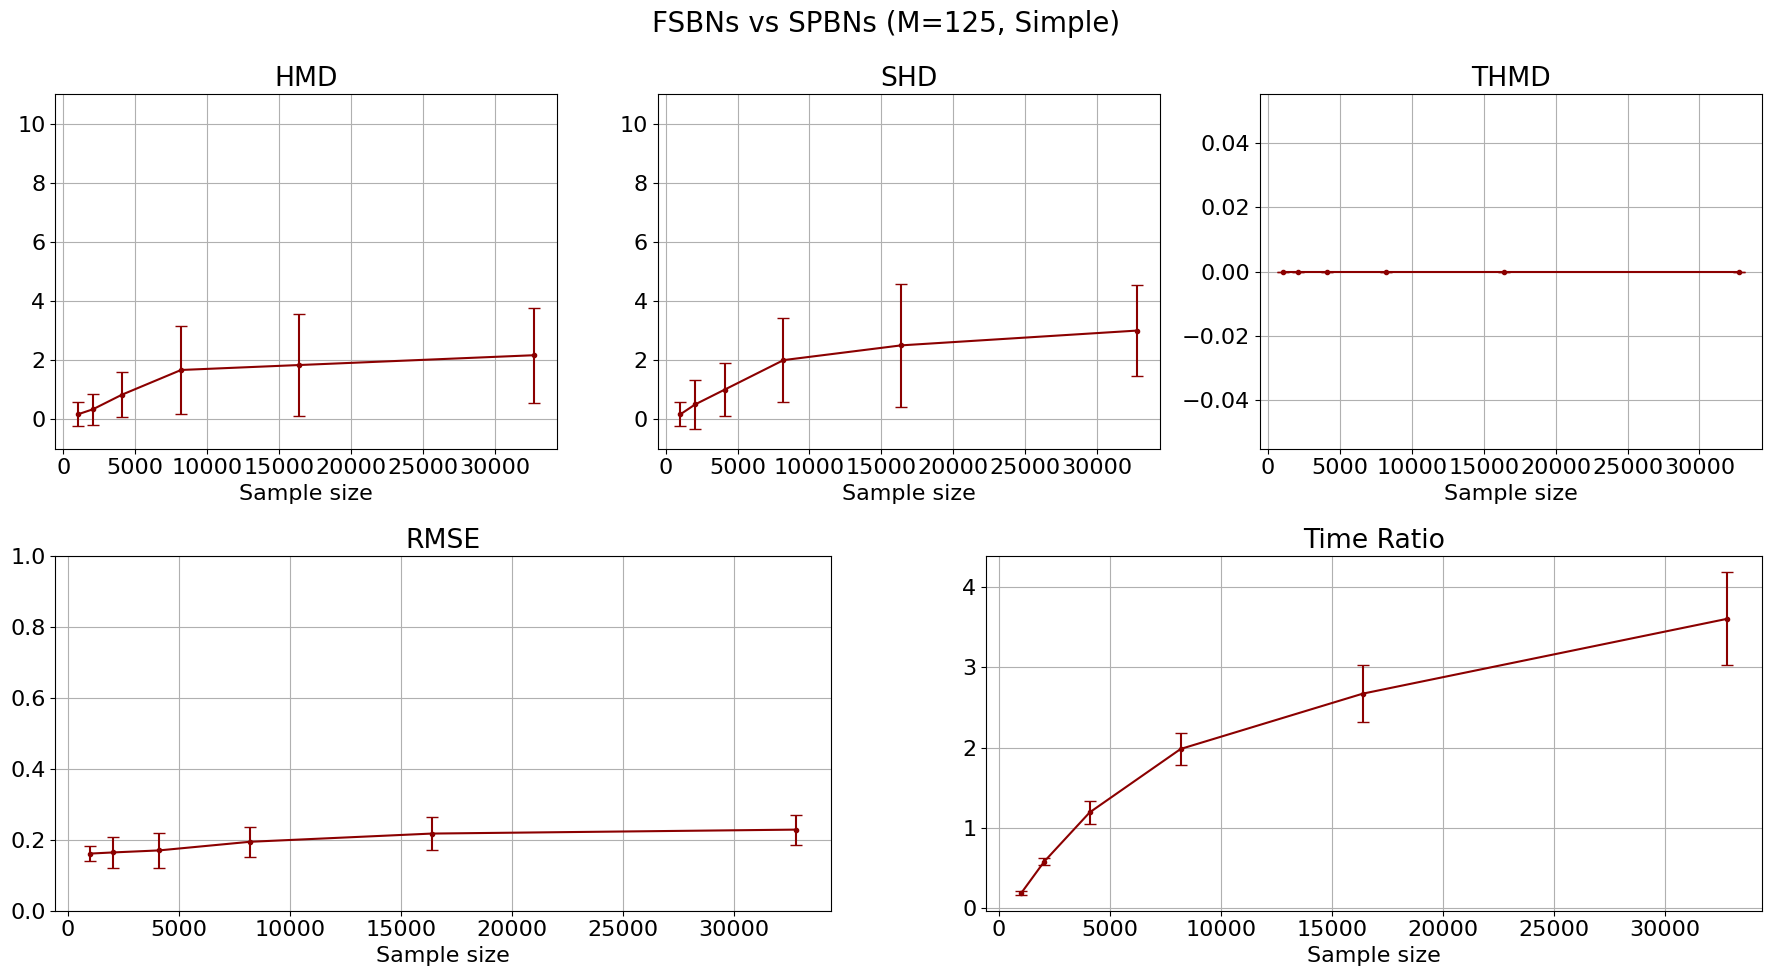

,instances,span,rmse,hamming,shamming,type_hamming,fbn_time,spbn_time,fbn_slogl,spbn_slogl,bridge,time_ratio
0,1024,e1v1,0.158230,0.0,0.0,0.0,5.862751,0.920499,-37298.657945,-37294.870423,1,0.157008
0,1024,e1v2,0.155847,1.0,1.0,0.0,5.230153,0.981477,-36348.400818,-36322.987841,1,0.187657
0,1024,e1v3,0.177060,0.0,0.0,0.0,6.521136,1.308567,-35799.733090,-35782.634041,1,0.200665
0,1024,e2v1,0.144556,0.0,0.0,0.0,5.586578,1.264558,-34686.513659,-34675.303137,2,0.226357
0,1024,e2v2,0.194865,0.0,0.0,0.0,6.570457,1.200165,-36639.414486,-36601.551548,2,0.182661
0,1024,e2v3,0.137107,0.0,0.0,0.0,6.393178,1.170244,-36212.851918,-36194.196336,2,0.183046
0,2048,e1v1,0.145988,0.0,0.0,0.0,6.973786,4.245502,-36797.721965,-36772.044434,1,0.608780
0,2048,e1v2,0.166599,1.0,1.0,0.0,6.531048,4.133353,-35641.519286,-35611.278954,1,0.632877
0,2048,e1v3,0.154058,0.0,0.0,0.0,8.454988,4.997940,-35331.775616,-35299.017058,1,0.591123
0,2048,e2v1,0.149568,0.0,0.0,0.0,6.884396,3.731786,-34045.956741,-34007.805124,2,0.542064


In [5]:
import json
from util_funcs import *


# Load the dictionary from the JSON file
with open('results/Mfix/exp7_simple/M125/Mfixed.json', 'r') as json_file:
    results_dict = json.load(json_file)

instances = [int(k) for k in results_dict.keys()]
stringify = lambda x: [[k,str(v)] for k,v in x]
avg_metrics = []
avg_spans_distances = []

for n in instances:
    dag_list_fbn, dag_list_spbn, nodetypes_fbn, nodetypes_spbn = [], [], [], []
    times_np = np.zeros((6,2))
    slogls_np = np.zeros((3,2))
    for span, results in results_dict[str(n)].items():
        
        nodemap = results['nodemap']
        rmse = results['distances']['rmse']
        fbn_time, fbn_slogl, avg_fbn_kargs = return_results(results['FSBN'],nodemap)
        spbn_time, spbn_slogl, avg_spbn_kargs = return_results(results['SPBN'],nodemap)
        
        avg_fbn = pbn.FourierNetwork(**avg_fbn_kargs)
        avg_spbn = pbn.SemiparametricBN(**avg_spbn_kargs)
        nodes_fbn = avg_fbn.node_types()
        nodes_spbn = avg_spbn.node_types()
        dag_matrix_fbn = arcs_to_DAG(avg_fbn.arcs(), nodemap)
        dag_matrix_spbn = arcs_to_DAG(avg_spbn.arcs(), nodemap)

        dag_list_fbn.append(dag_matrix_fbn.tolist())
        dag_list_spbn.append(dag_matrix_spbn.tolist())
        nodetypes_spbn.append(stringify(nodes_spbn.items()))
        nodetypes_fbn.append(stringify(nodes_fbn.items()))
        
        pdag_fbn = avg_fbn.clone()
        pdag_fbn = pdag_fbn.graph().to_pdag()
        pdag_spbn = avg_spbn.clone()
        pdag_spbn = pdag_spbn.graph().to_pdag()


        path = f'results/Mfix/exp7_simple/M125/avg_nets/N{n}/{span}'
        if not os.path.exists(path):
            os.makedirs(path)
        draw_model(avg_fbn,path+'/fsbn')
        draw_model(avg_spbn,path+'/spbn')
        draw_model_pdag(pdag_fbn,path+'/fsbn_pdag')
        draw_model_pdag(pdag_spbn,path+'/spbn_pdag')

        # fig = plt.figure(figsize=(20,10))
        # for m, model in enumerate([avg_fbn, avg_spbn]):
        #     ax = fig.add_subplot(1,2,m+1)
        #     plot_both_models(model, ax)
            
        # fig.tight_layout()
        # fig.savefig(path +'/both.pdf', format='pdf',bbox_inches="tight")
        # fig.show()
        


        hamming = hamming_distance(avg_fbn.arcs(), avg_spbn.arcs(), nodemap)
        shamming = structural_hamming_distance(avg_fbn.arcs(), avg_spbn.arcs(),)
        type_hamming = node_type_hamming_distance(avg_fbn.node_types(), avg_spbn.node_types())

        # hamming  = np.array(results['distances']['hmd']).astype(float)
        # shamming = np.array(results['distances']['shd']).astype(float)
        # type_hamming = np.array(results['distances']['thmd']).astype(float)
        
        hamings_df = pd.DataFrame({'instances':[n], 'span':[span], 'rmse':[np.mean(rmse)],
                                #    'hamming':[hamming], 'shamming':[shamming], 'type_hamming':[type_hamming],
                                
                                   'hamming':[np.mean(hamming)], 'shamming':[np.mean(shamming)], 'type_hamming':[np.mean(type_hamming)],
                                   'fbn_time':[np.mean(fbn_time)],  'spbn_time':[np.mean(spbn_time)], 
                                   'fbn_slogl':[np.mean(fbn_slogl)], 'spbn_slogl':[np.mean(spbn_slogl)]})
        
        avg_metrics.append(hamings_df.copy())

    
    span_avg_fbn = {'time': [],
                    'slogl': [],
                    'network':{'DAGS': dag_list_fbn, 'node_types': nodetypes_fbn}     
                    }
    span_avg_spbn = {'time': [],
                    'slogl': [],
                    'network':{'DAGS': dag_list_spbn, 'node_types': nodetypes_spbn}
                    }
                    
    _, _, avg_fbn_kargs2 = return_results(span_avg_fbn, nodemap)
    _, _, avg_spbn_kargs2 = return_results(span_avg_spbn, nodemap)
    
    avg_fbn_spans = pbn.FourierNetwork(**avg_fbn_kargs2)
    avg_spbn_spans = pbn.SemiparametricBN(**avg_spbn_kargs2)
    hamming = hamming_distance(avg_fbn_spans.arcs(), avg_spbn_spans.arcs(), nodemap)
    shamming = structural_hamming_distance(avg_fbn_spans.arcs(), avg_spbn_spans.arcs(),)
    type_hamming = node_type_hamming_distance(avg_fbn_spans.node_types(), avg_spbn_spans.node_types())

    hamings_spans_df = pd.DataFrame({'instances':[n], 
                                   'hamming':[hamming], 'shamming':[shamming], 'type_hamming':[type_hamming]})
    avg_spans_distances.append(hamings_spans_df.copy())
    
    path = f'results/Mfix/exp7_simple/M125/avg_nets/N{n}/avg_net'
    if not os.path.exists(path):
        os.makedirs(path)
    # draw_model(avg_fbn_spans, path+'/fsbn')
    # draw_model(avg_spbn_spans, path+'/spbn')


    # fig = plt.figure(figsize=(20,10))
    # for m, model in enumerate([avg_fbn_spans, avg_spbn_spans]):
    #     ax = fig.add_subplot(1,2,m+1)
    #     plot_both_models(model, ax)
        
    # fig.tight_layout()
    # fig.savefig(f'results/Mfix/exp7_simple/M125/avg_nets/N{n}/both_avg_net.pdf', format='pdf',bbox_inches="tight")
    # # fig.show()
    

metrics_df = pd.concat(avg_metrics)
metrics_spans_avg = pd.concat(avg_spans_distances)
metrics_df['bridge'] = metrics_df['span'].map(lambda x: x[:2]).replace({'e1':1,'e2':2})

metrics_df['time_ratio'] = metrics_df['spbn_time']/metrics_df['fbn_time']
mean_metrics = metrics_df.drop(columns=['span']).groupby('instances').mean().reset_index()
std_metrics = metrics_df.drop(columns=['span']).groupby('instances').std().reset_index()
print(metrics_spans_avg)
mean_metrics_spans_AVG = metrics_spans_avg.groupby('instances').mean().reset_index()
std_metrics_spans_AVG = metrics_spans_avg.groupby('instances').std().reset_index()
# mean_metrics = metrics_df.drop(columns=['span']).groupby(np.arange(len(metrics_df)) // 3).mean().reset_index(drop=True)
# std_metrics = metrics_df.drop(columns=['span']).groupby(np.arange(len(metrics_df)) // 3).std().reset_index(drop=True)

plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18, 10), layout="constrained")
fig.suptitle(f'FSBNs vs SPBNs (M={hasM}, Simple)', fontsize=20)
gs0 = fig.add_gridspec(2, 1)

# Create subgridspecs for the upper and lower grids
gs00 = gs0[0].subgridspec(1, 3)
gs10 = gs0[1].subgridspec(1, 2)

# Create axes from the subgridspecs
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[0, 1])
ax3 = fig.add_subplot(gs00[0, 2])
ax4 = fig.add_subplot(gs10[0, 0])
ax5 = fig.add_subplot(gs10[0, 1])

ax1.set_title('HMD')
ax1.set_xlabel('Sample size')
ax1.set_ylim(-1,11)

ax2.set_title('SHD')
ax2.set_xlabel('Sample size')
ax2.set_ylim(-1,11)

ax3.set_title('THMD')
ax3.set_xlabel('Sample size')

ax4.set_title('RMSE')
ax4.set_xlabel('Sample size')
ax4.set_ylim(0,1)


ax5.set_title('Time Ratio')
ax5.set_xlabel('Sample size')

for brdg in [1.5]:
# for brdg in [1,2]:
    means = mean_metrics[mean_metrics['bridge']==brdg]
    stds = std_metrics.iloc[means.index,:]

    # ax1.plot(metrics_spans_avg['instances'], metrics_spans_avg['hamming'],color='dimgray', marker='o', linestyle='--', markersize=3, 
                #  label=f'2/3 Threshold')
    ax1.errorbar(x=means['instances'], y=means['hamming'], yerr=stds['hamming'], color='darkred' , fmt='o', linestyle='-', capsize=4, markersize=3, 
                 label=f'Means')
    ax1.grid(True)

    # ax2.plot(metrics_spans_avg['instances'], metrics_spans_avg['shamming'],  color='dimgray', marker='o', linestyle='--', markersize=3, 
                #  label=f'2/3 Threshold')
    ax2.errorbar(x=means['instances'], y=means['shamming'], yerr=stds['shamming'], color='darkred', fmt='o', linestyle='-', capsize=4, markersize=3, 
                 label=f'Means')
    ax2.grid(True)

    # ax3.plot(metrics_spans_avg['instances'], metrics_spans_avg['type_hamming'], color='dimgray', marker='o', linestyle='--', markersize=3, 
                #  label=f'2/3 Threshold') 
    ax3.errorbar(x=means['instances'], y=means['type_hamming'], yerr=stds['type_hamming'], color='darkred', fmt='o', linestyle='-', capsize=4, markersize=3, 
                 label=f'Means')
    ax3.grid(True)

    ax4.errorbar(x=means['instances'], y=means['rmse'], yerr=stds['rmse'], color='darkred', fmt='o', linestyle='-',  capsize=4, markersize=3, 
                 label=f'Means')
    ax4.grid(True)

    ax5.errorbar(x=means['instances'], y=means['time_ratio'], yerr=stds['time_ratio'], color='darkred', fmt='o', linestyle='-',  capsize=4, markersize=3, 
                 label=f'Means')
    # ax5.errorbar(x=means['instances'], y=means['fbn_time'], yerr=stds['fbn_time'], fmt='o', linestyle='-',  capsize=4, markersize=3, label=f'E{int(brdg)}')
    # ax5.errorbar(x=means['instances'], y=means['spbn_time'], yerr=stds['spbn_time'], fmt='o', linestyle='-',  capsize=4, markersize=3, label=f'E{int(brdg)}')
    ax5.grid(True)


handles, labels = [], []
for ax in [ax1, ax2, ax3, ax4, ax5]:
    # ax.set_xlim(0,2**15)
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:  # Check to avoid duplicates
            handles.append(handle)
            labels.append(label)
# fig.legend(handles, labels,loc='upper right', borderaxespad=-0.2)
# fig.legend(handles, labels,loc='upper right', bbox_to_anchor=(0.98, 1.02), borderaxespad=0.)
fig.tight_layout()
# fig.savefig(f'results/Mfix/exp7_simple/M125/M{hasM}_simple_means_all.pdf', format='pdf',bbox_inches="tight")
plt.show()

metrics_df

In [7]:
avg_fbn.arcs()
avg_fbn.node_types()

{'NAT_FREQ1_Hz_': FBKernelType,
 'NAT_FREQ0_Hz_': FBKernelType,
 'DAMP_FAC2_-_': FBKernelType,
 'DAMP_FAC1_-_': FBKernelType,
 'NAT_FREQ2_Hz_': FBKernelType,
 'DAMP_FAC0_-_': FBKernelType}

In [1]:
csvs = sorted(glob.glob('data/aingura/dfg/*.csv'))
data = pd.read_csv(csvs[0],sep=';')
datasampl = data.sample(2048).iloc[:,1:]
print(datasampl)
avg_fbn.fit(datasampl, grid=125, linear=False)
avg_fbn.sample(1000)

NameError: name 'glob' is not defined

In [ ]:
metrics_df.to_csv('results/Mfix/exp7_simple/M125/avg_metrics.csv', index=False)

In [ ]:
types = {'NAT_FREQ1_Hz_': pbn.LinearGaussianCPDType(),'NAT_FREQ2_Hz_': pbn.CKDEType(), 'NAT_FREQ3_Hz_': pbn.CKDEType()}
net = pbn.SemiparametricBN(nodes=list(types.keys()), node_types =list(types.items()))
stringify = lambda x: [[k,str(v)] for k,v in x]
stringify(net.node_types().items())

In [ ]:
json_DAGS[n][f'{span}']['FSBN'] = {'time': times_np[:,0].tolist(), 
                                               'slogl': slogls_np[:,0].tolist(),
                                               'network':{'DAGS': dag_list_fbn, 'node_types': nodes_fbn}}
            
            json_DAGS[n][f'{span}']['SPBN'] = {'time': times_np[:,1].tolist(),
                                               'slogl': slogls_np[:,1].tolist(),
                                               'network':{'DAGS': dag_list_spbn, 'node_types': nodetypes_spbn}}
            
            json_DAGS[n][f'{span}']['distances'] = {'hmd': hamming_np.tolist(), 
                                                    'shd': shamming_np.tolist(), 
                                                    'thmd': type_hamming.tolist(), 
                                                    'rmse': rmse_np.tolist()}

In [ ]:
nodemap = {}

nodes = data.columns[1:]
for nc in range(len(nodes)):
    nodemap[nodes[nc]] = nc
nodemap

In [ ]:
fft = True
M = 100
dataf_sampl = data.sample(2**14, random_state=15)




hc = pbn.GreedyHillClimbing()
vl = pbn.CVLikelihoodFT(dataf_sampl, k=5, grid_size= M, seed=0)
start_fbn = pbn.FourierNetwork(nodes=nodes)
start_spbn = pbn.SemiparametricBN(nodes=nodes)
pool = pbn.OperatorPool([pbn.ArcOperatorSet(), pbn.ChangeNodeTypeSet()])


In [ ]:
n=0
pathsave = f'results/exp{n}/{start_fbn}/M{M}'
if not os.path.exists(pathsave):
    os.makedirs(pathsave)


print(f"Start {start_fbn} estimation with {dataf_sampl.shape[0]} and grid size of {M}")
start = time.time()
model = hc.estimate(operators = pool, score = vl, start = start_fbn)
model.fit(dataf_sampl)
logl_ft = model.logl(dataf_sampl)
end = time.time()
print(f'{start_fbn} HC Elapsed time: {end-start}')
print(f'{start_fbn} Mean logl: {np.mean(logl_ft)}')


draw_model(model, pathsave +f'/model_{start_fbn}')
logldf = pd.DataFrame({'score': logl_ft})
logldf.to_csv(pathsave +f'/logl_{start_fbn}.csv', index=False)

In [ ]:
n=0
pathsave = f'results/exp{n}/{start_spbn}/M{M}'
if not os.path.exists(pathsave):
    os.makedirs(pathsave)


print(f"Start {start_spbn} estimation with {dataf_sampl.shape[0]} and grid size of {M}")
start = time.time()
model = hc.estimate(operators = pool, score = vl, start = start_spbn)
model.fit(dataf_sampl)
logl_ft = model.logl(dataf_sampl)
end = time.time()
print(f'{start_spbn} HC Elapsed time: {end-start}')
print(f'{start_spbn} Mean logl: {np.mean(logl_ft)}')


draw_model(model, pathsave +f'/model_{start_spbn}')
logldf = pd.DataFrame({'score': logl_ft})
logldf.to_csv(pathsave +f'/logl_{start_spbn}.csv', index=False)